# 준지도학습 기반의 대조적 사전학습 모델 (SimCLR) 을 이용한 이미지 분류

**지은이:** [András Béres](https://www.linkedin.com/in/andras-beres-789190210)<br>
**옮긴이**: [Janghoo Lee](https://www.linkedin.com/in/janghoo-lee-25212a1a0/)<br>
**원본노트북:** [Semi-supervised image classification using contrastive pretraining with SimCLR](https://keras.io/examples/vision/semisupervised_simclr/)<br>
**원본작성일:** 2021/04/24<br>
**최종수정일:** 2021/04/24<br>
**번역일:** 2021/08/15<br>
**번역최종수정일:** 2021/10/11<br>
**설명:** SimCLR 에서 제안하는 대조학습 기반의 사전학습<sub>contrastive pretraining</sub>을 STL-10 데이터셋에 적용하여 이미지 분류 문제를 풀어냅니다.

**선행 추천 노트북** <br>

Eng : [Image similarity estimation using a Siamese Network with a contrastive loss](https://keras.io/examples/vision/siamese_contrastive/) <br>

<br>

*이 노트북은 2021 Open Source Contribution Contribution Academy, Keras Korea 의 지원을 받아 제작되었습니다. 한국어로 옮겨진 노트북은 이해를 돕기 위해 원본 노트북에서 제공하는 설명에 대해 추가적인 내용이 들어가 있음을 알립니다. 원문 설명은 [원본 노트북](https://keras.io/examples/vision/semisupervised_simclr/)을 참고하세요.*

## 들어가며

### 준지도학습 (자기지도학습)

준지도학습<sub>semi-supervised learning</sub> 또는 자기지도학습<sub>self-supervised learning</sub> 은 "**부분적으로 레이블링된 데이터셋**" 을 다루는 머신러닝의 새로운 패러다임입니다. 현실세계의 특정 문제에 딥러닝을 적용하려고 한다면, 딥러닝 모델이 잘 동작하도록 학습시키기 위해 엄청나게 많은 양의 데이터를 수집해야 합니다. 이렇게 모은 데이터에 레이블을 하나하나 붙이는 데 걸리는 시간은 데이터의 양에 대해 선형적<sub>linear</sub> 으로 증가합니다. 예를 들어, 개와 고양이 이미지 100개를 모으든 1000개를 모으든 데이터셋 하나에 개, 고양이를 붙이는 데 들어가는 시간이 10 초로 변하지 않는다는 의미입니다. 반면 딥러닝 모델의 성능은 데이터의 양에 대해 [선형이 아닙니다.<sub>sublinear</sub>](https://arxiv.org/abs/2001.08361) 즉, 데이터셋에 100장의 사진을 꾸준히 추가하더라도, 추가의 100장을 투입함으로써 얻을 수 있는 성능 증가분은 점점 줄어들기 때문에, 동일한 추가 비용을 통해 얻게 되는 모델의 성능은 점점 줄어들기 때문에 비효율적입니다. 반면 레이블링되지 않은 데이터를 모으는 일은 훨씬 저렴합니다.

준지도 학습은 앞서 언급했듯 오직 "부분적으로 레이블링된 데이터셋" 을 활용하는 패러다임이기 때문에 데이터수집의 비용효율 문제를 해결하고, 레이블링되지 않은 수많은 데이터를 멋지게 활용할 단서가 될 수 있습니다.

이번 노트북에서는 constrative learning 와 라벨링되지 않은 100,000 장의 [STL-10](https://ai.stanford.edu/~acoates/stl10/) 이미지를 이용해서 함께 인코더를 사전학습<sub>pretrain</sub> 시킨 뒤, 라벨링된 500 장의 적은 데이터로 파인튜닝<sub>fine-tuning</sub> 을 시켜볼 것입니다.


### 대조 학습

대조학습을 적용한 모델의 핵심 아이디어는 준지도학습 방식을 통해 (레이블이 없는 이미지를 통해) "**이미지의 변형에 강인한 표현을 배운다**" 입니다. 하지만 모델에게 "이미지 각각에 대해서 고유한 표현을 만들어내도록 해!" 처럼 단순히 이런 목표를 만들어 준다면, 이미지 각각에 의존하는 것이 아니라 어느 이미지에도 항상 동일한 (상수의) 표현을 가진다고 학습하는 모습을 볼 수 있을 것입니다. 조금 어렵게 말하면, 모델이 "**trivial degenerate solution**" (이를  **collapsing** 이라고 부르기도 합니다.) 으로 수렴해 버리는 문제에 빠질 수 있다고 표현할 수 있습니다.

대조학습은 위에서 걱정한 문제 (trivial degnerate solution 에 빠져 버리는 문제) 를 막기 위해 다양한 방법들을 제시합니다. 대표적인 예로, 이 노트북에서 소개하는 [SimCLR](https://arxiv.org/abs/2002.05709) 에서는 이미지의 표현 벡터 사이에서 밀기와 당기기 두 가지를 유도합니다. 이를 이해하기 위해 데이터셋에 이미지 [A, B] 가 있다고 생각해 봅시다. A 를 인위적으로 변형시킨 결과물이 A', A'' 이고, B 를 변형시킨 결과물이 B', B'' 입니다. 대조학습은 (1) A, A', A''... 이들끼리는 실제로 동일한 이미지로부터 파생되었기 때문에, 이미지 고유의 표현<sub>representation</sub>을 학습하도록 유도하는 방식으로 작동합니다. 이를 대조적 유사<sub>contrasting positive</sub> (당기기 유도) 이라고 합니다. 또한, 대조학습은 A 와 B, A' 와 B 혹은 A'', B' 와 같이 완전히 근본이 다른 이미지들끼리는 서로 밀어내도록 유도합니다. 이를 대조적 차이<sub>contrasting negative</sub> (밀어내기 유도) 라고 합니다. 이렇게 모델이 이미지 고유의 표현을 학습하는 과정 중 표현들 사이에서 끌어당기기와 밀어내기를 둘 다 유도함으로써 앞서 우려했던 "trivial degenerate solution" 에 빠지는 것을 막을 수 있습니다. 단순히 "이미지 각각에 대해 고유한 표현벡터를 가지도록 학습해!" 가 아니라, "동일한 이미지로부터 생성된 이미지끼리는 동일한 표현을 가지도록 학습하고, 다른 이미지로부터 생성된 이미지끼리는 다른 표현을 가지도록 학습해!" 라는 임무를 준다고 생각하면 됩니다.

이것과 약간 다른 접근은 [SimSiam](https://arxiv.org/abs/2011.10566) 입니다. SimCLR 과 SimSiam 이 보여주는 접근의 가장 큰 차이는 손실에 밀어내는<sub>negative</sub> 요소가 없다는 점입니다. 즉, SimCLR 과 같이 벡터들 사이에서 밀기와 당기기를 모두 사용하는 방식을 통해 명시적으로 trivial solution 을 막아주지는 않기 때문에, SimSiam 은 네트워크 아키텍처와 다른 기법들에 의존하게 됩니다. 약간의 스포일러를 하자면, SimCLR 에서는 A, A', B, B' 와 같이 동일한 이미지로부터 파생된 쌍과 다른 이미지로부터 파생된 쌍 둘 모두를 동일한 네트워크 f 에 통과시키지만, SimSiam 에서는 동일한 이미지로부터 파생된 쌍 A, A' 을 각각 f, f' 에 통과시킵니다. f 와 f' 의 구조는 조금 다르기 때문에, 비대칭적 인코딩 과정<sub>asymetric encoding paths</sub> 을 거친다고 표현합니다.

SimCLR 에 대해서 더 궁금하다면, 공식 [Google AI blog post](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html) 를 참고하세요. 준지도학습이 언어모델과 비전모델 전반에서 어떤 아이디어를 가지고 연구되는지 궁금하다면 [이 블로그 포스팅](https://ai.facebook.com/blog/self-supervised-learning-the-dark-matter-of-intelligence/)을 참고하세요. SimSiam 에서 더 궁금하면, [케라스 예제](https://keras.io/examples/vision/simsiam/) 를 확인해 보는 것도 좋습니다.

## 환경 준비하기

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## 초매개변수 설정

In [ ]:
# 데이터세트 관련 초매개변수
unlabeled_dataset_size = 100000
labeled_dataset_size = 5000
image_size = 96
image_channels = 3

# 훈련/알고리듬 초매개변수
num_epochs = 20
batch_size = 525 # 1 에폭에 200 스텝이 나오도록 배치 사이즈를 세팅합니다.
width = 128
temperature = 0.1
# 준지도학습, 대조학습을 위한 높은 강도의 이미지 변형과 지도학습 데이터에 적용되기 위한 낮은 강도의 이미지 변형이 필요합니다.
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

## 데이터셋

훈련 과정에서 커다란 배치 사이즈의 레이블링 되지 않은 이미지와, 그보다 훨씬 적은 양의 레이블링된 이미지를 동시에 불러올 것입니다.

In [ ]:
def prepare_dataset():

    # 라벨링된 이미지와 라벨링되지 않은 이미지를 적절한 배치 사이즈로 동시에 가져옵니다.
    steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
    unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
    labeled_batch_size = labeled_dataset_size // steps_per_epoch
    print(
        f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
    )

    unlabeled_train_dataset = (
        tfds.load("stl10", split="unlabelled", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=10 * unlabeled_batch_size)
        .batch(unlabeled_batch_size)
    )
    labeled_train_dataset = (
        tfds.load("stl10", split="train", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=10 * labeled_batch_size)
        .batch(labeled_batch_size)
    )
    test_dataset = (
        tfds.load("stl10", split="test", as_supervised=True)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # 레이블링된, 레이블링되지 않은 데이터셋이 함께 zip() 으로 패킹됩니다.
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, labeled_train_dataset, test_dataset


# STL10 데이터셋을 가져옵니다.
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

print(train_dataset)
print(labeled_train_dataset)
print(test_dataset)

batch size is 500 (unlabeled) + 25 (labeled)
<PrefetchDataset shapes: (((None, 96, 96, 3), (None,)), ((None, 96, 96, 3), (None,))), types: ((tf.uint8, tf.int64), (tf.uint8, tf.int64))>
<BatchDataset shapes: ((None, 96, 96, 3), (None,)), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, 96, 96, 3), (None,)), types: (tf.uint8, tf.int64)>


## 이미지 변형 (이미지 증강)

대조학습을 위해 가장 중요한 두 변형은 아래와 같습니다.
- 잘라내기<sub>cropping</sub> : 모델이 하나의 이미지에서도 다른 부분을 인코딩하도록 강제하기 위함입니다. 우리는 이 노트북에서 [랜덤평행이동](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_translation/)<sub>RandomTranslation</sub> 과 [랜덤확대축소](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_zoom/)<sub>RandomZoom</sub> 레이어를 통해 구현합니다.
- 색상변형<sub>color jitter</sub> : 색상의 채도, 명도, 밝기를 조금씩 변형합니다. 모델이 색상 히스토그램을 바탕으로 수렴해 버리는 현상을 막기 위함입니다. 이 변환을 구현하는 아주 기본적인 방법은 색상 공간에서 아핀 변환<sub>affine transformations</sub> 이 적용되도록 만드는 것입니다.

이 노트북에서는 수평방향 뒤집기<sub>horizontal flip</sub> 도 많이 사용합니다. 

자기지도학습<sub>self-supervised</sub> 과 대조학습을 위한 높은 강도의 이미지 변형과 지도학습을 위한 낮은 강도의 이미지 변형이 필요합니다. 보통 데이터 증강은 CPU 에서 일어나는 경우가 많습니다. 하지만 tf.keras 의 데이터 변형 레이어를 사용한다면, 데이터 변형은 GPU 에서 배치 단위로 수행되기 때문에 훈련 파이프라인의 병목이 아닙니다.

우리는 이 노트북에서 색상변형<sub>color jitter</sub> 을 구현하기 위해 커스텀 전처리 레이어를 구현해볼 것입니다. 이러한 이미지 변형을 위한 전처리 "레이어" 를 직접 구현하면 다음과 같은 장점들이 있습니다.

1. 데이터 변형 과정이 GPU 에서 배치 단위로 수행되기 때문에, 데이터 변형 과정이 훈련 파이프라인의 병목이 아니게 됩니다.
2. 데이터 전처리 (데이터 변형 과정을 포함하는) 파이프라인이 모델 안에 포함되어버리기 때문에, 배포 시에 각 모델에 맞는 전처리 함수들을 환경과 모델에 맞게 다시 구현해야 하는 수고가 줄어듭니다.

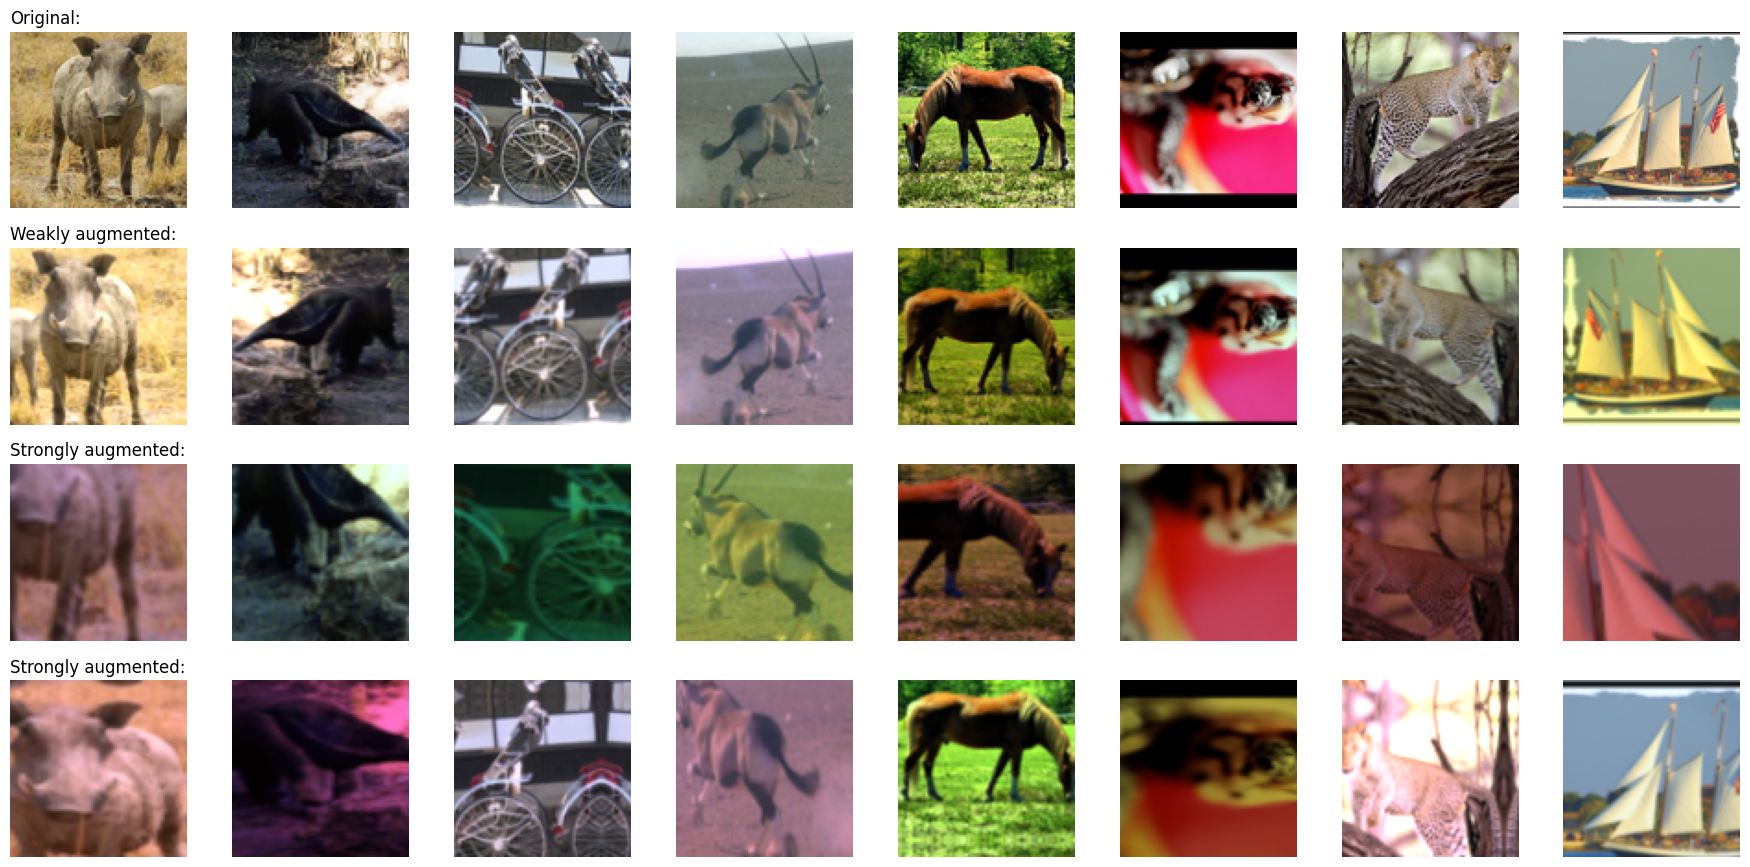

In [ ]:
# 이미지의 색상을 왜곡시킵니다.
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # 모든 색상에 대해서 동일하게 적용됩니다.
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            ) # [b,1,1,1]

            # 모든 색상마다 다르게 적용됩니다.
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            ) # [b,1,3,3]

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            ) # [b,1,3,3]
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)

        return images


# 이미지 변형 모듈입니다.
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - tf.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            preprocessing.Rescaling(1 / 255),
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            preprocessing.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )


def visualize_augmentations(num_images):

    # 데이터셋에서 1개 배치를 가져옵니다.
    images = next(iter(train_dataset))[0][0][:num_images]

    # 이미지 변형을 적용합니다.
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

## 인코더

아주 간단한 인코더를 설계합니다.

In [ ]:
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

## 지도학습 베이스라인 모델

가중치 랜덤 초기화<sub>random initialization</sub> 이후, 지도학습을 통해 학습시켜 볼 베이스라인 모델을 설계합니다.

In [ ]:
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(10),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 [==============================] - 24s 39ms/step - loss: 2.0412 - acc: 0.2288 - val_loss: 1.6669 - val_acc: 0.3697
Epoch 2/20
200/200 [==============================] - 6s 29ms/step - loss: 1.7371 - acc: 0.3420 - val_loss: 1.6654 - val_acc: 0.3798
Epoch 3/20
200/200 [==============================] - 6s 29ms/step - loss: 1.6161 - acc: 0.3888 - val_loss: 1.5700 - val_acc: 0.4166
Epoch 4/20
200/200 [==============================] - 6s 28ms/step - loss: 1.5337 - acc: 0.4282 - val_loss: 1.4821 - val_acc: 0.4346
Epoch 5/20
200/200 [==============================] - 6s 28ms/step - loss: 1.4716 - acc: 0.4504 - val_loss: 1.3590 - val_acc: 0.4877
Epoch 6/20
200/200 [==============================] - 6s 28ms/step - loss: 1.4012 - acc: 0.4722 - val_loss: 1.4381 - val_acc: 0.4719
Epoch 7/20
200/200 [==============================] - 6s 28ms/step - loss: 1.3498 - acc: 0.4886 - val_loss: 1.2561 - val_acc: 0.5290
Epoch 8/20
200/200 [==============================] - 6s 28ms/step -

## 대조학습을 위한 준지도학습 모델

이제 라벨링되지 않은 이미지에 대조 손실을 적용하여 인코더를 사전학습<sub>pretrain</sub> 시킬 것입니다. 인코더의 표현력을 더 향상시키기 위해 비선형 투영<sub>nonlinear projection</sub> 층은 인코더의 가장 상위레벨의 추상화된 피쳐<sub>top</sub>를 기반으로 학습하도록 붙여집니다.

이 노트북에서는 InfoNCE 손실, NT-Xent 손실, N-pairs 손실 이 셋과 밀접한 관련이 있는 대조학습 손실을 활용할 계획입니다. 이들의 공통적인 메커니즘을 조금 더 설명하면 아래와 같습니다.

1. 우리는 하나의 배치에 들어 있는 각 이미지 (이미지 A, 이미지 B, 이미지 C, ...) 를, 그 이미지 각각에 클래스가 붙어 있다고  (이미지 A - 클래스 A, 이미지 B - 클래스 B, 이미지 C - 클래스 C...) 생각합니다.
2. 우리는 이미지 A 를 변형시킨 이미지 A'' 그리고 A''' 와 같이, 하나의 이미지에 대해 변형시킨 한 쌍이 존재합니다. 다시 말하면, 1. 에서 이미지 각각이 하나의 클래스로 보기로 했으므로, 하나의 클래스에 대해 변형시킨 한 쌍이 존재합니다.
3. 각 클래스마다 변형된 이미지의 표현<sub>representation</sub> 을, 연결지을 수 있는 모든 변형된 이미지와 비교합니다.
4. 3에서 비교하는 대상들에 온도변수로 스케일링된<sub>temperature-scaled</sub> 코사인유사도를 logit 으로 사용합니다.
5. 마지막으로 분류 손실로 크로스-엔트로피 손실을 적용합니다.


평가지표는 두 가지를 사용합니다.
- 준지도학습 평가지표 1.대조 정확도<sub>Constrative accuracy</sub> [(SimCLR 논문의 표 5)](https://arxiv.org/abs/2002.05709) :  준지도학습의 평가지표로, 한 영상의 표현 벡터(a) 와 그 영상의 변형된 버전의 표현 벡터와의 유사도(a') 가, 다른 영상의 표현 벡터(b) 와의 유사도보다 더 유사하다고 느껴지는 샘플의  비율입니다. 즉, a\~a' 가 a\~b 보다 유사한 샘플의 비율입니다.
- 준지도학습 평가지표 2.[선형탐사정확도](https://arxiv.org/abs/1603.08511)<sub>Linear probing accuracy</sub> : 선형탐사는 인코더 특징의 top 에서 분류 손실을 통해 학습되는 단 1개의 로지스틱 분류기입니다. 이 노트북에서는 인코더의 최상부 (최상위 피쳐를 기반으로 학습하는) 에 추가하는 한 개의 완전연결층으로 구현됩니다. 물론 최근 딥러닝의 경향은 사전학습이 끝난 뒤 분류기부분만 추가로 학습하는 양상을 보이는 것과는 반대로 이 노트북에서는 이 분류기를 훈련 도중에 동시에 학습시킵니다. 이러한 방식은 모델의 정확도 등 성능을 조금 떨어뜨릴 수 있지만, 이 선형탐사정확도가 변화하는 모습을 실시간으로 살펴볼 수 있으므로 재미있고 디버깅도 편할 것입니다.

인코더 특징의 top 에서 학습되는 지도학습 성능 평가 지표로는 [KNN 군집화 정확도](https://arxiv.org/abs/1805.01978) 또한 자주 사용되지만, 이 노트북에서는 구현되어 있지 않습니다.

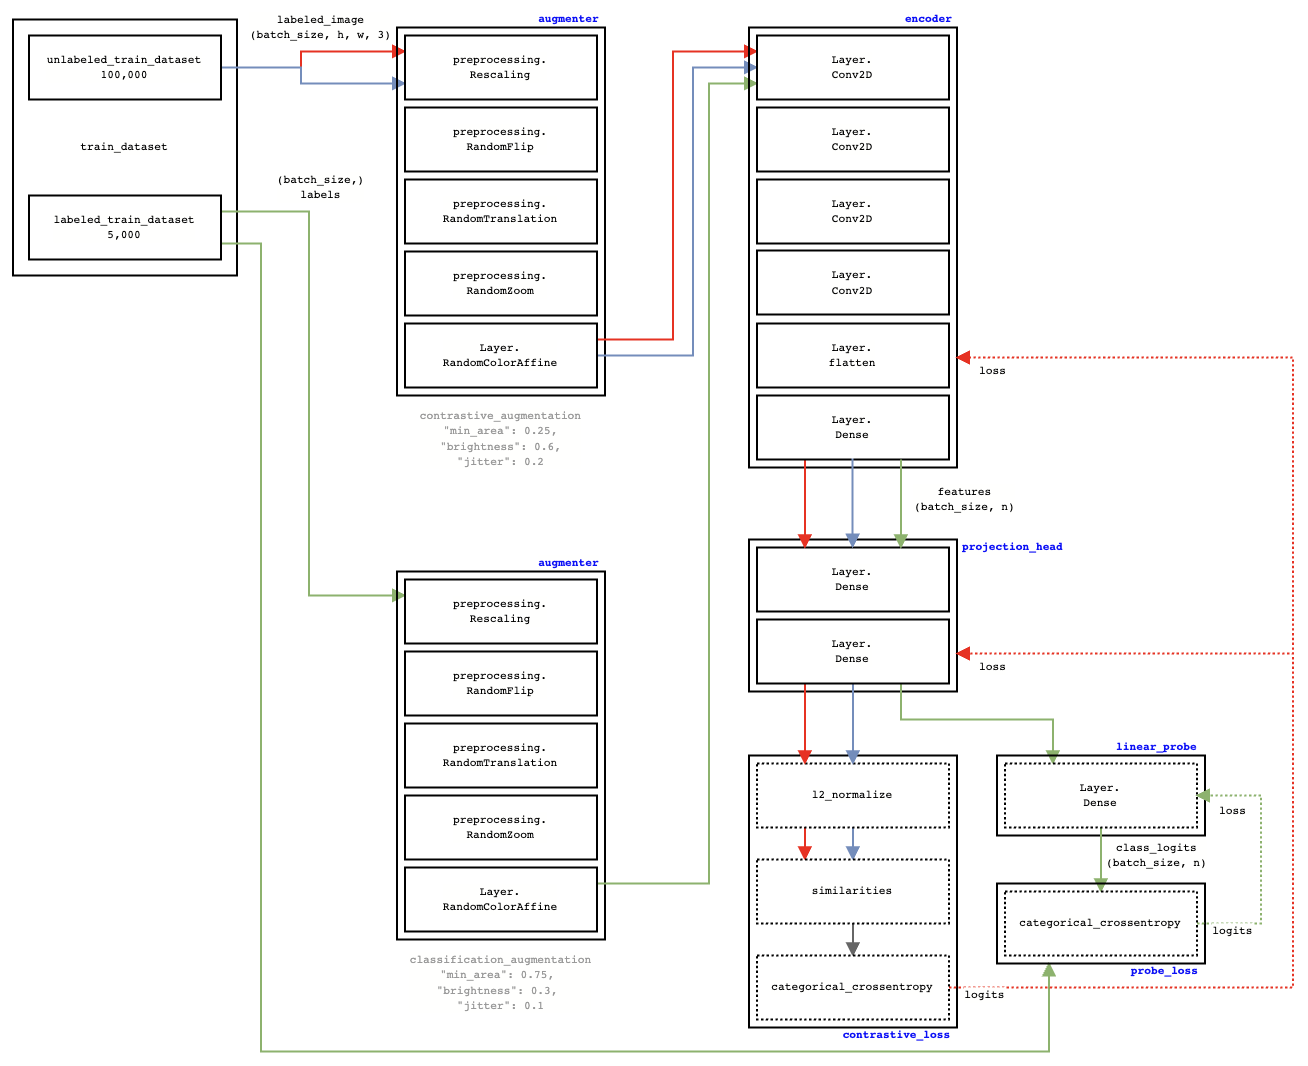

In [ ]:
# 케라스 모델 클래스 서브클래싱을 통해 대조학습 모델을 정의합니다.
# 케라스 모델을 생성하는 방법에는 크게 서브클래싱 API 와 함수형 API 가 있습니다.
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        
        # 비선형 투영의 목적으로 사용되는 다층 퍼셉트론
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        
        # 선형탐사 정확도 계산을 위한 1개의 완전연결층
        self.linear_probe = keras.Sequential(
            [
                layers.Input(shape=(width,)), 
                layers.Dense(10)
            ],
            name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss 는 메소드(def contrastive_loss) 로 정의되어 있습니다.
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(name="c_acc")
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE 손실 (information noise-contrastive estimation)
        # NT-Xent 손실 (normalized temperature-scaled cross entropy)

        # projections_1, projections_2 는 모두 batch_size 개의 벡터입니다. (batch_size, n)

        # 코사인 유사도: 특징 벡터에 L2 정규화를 한 뒤 (softmax 연산을 한 것이 아닙니다!), 내적연산을 해서 얻을 수 있습니다.
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            # 내적의 결과를 temperature 파라미터로 나누어 줍니다.
            # tf.matmul(a, b) 에서 transpose_b 를 하면 a 와 b 의 내적을 계산합니다.
            # a   : (batch_size, width) 
            # b.T : (width, batch_size)
            # return : (batch_size, batch_size)
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )
        # 이 similarities 행렬의 각 요소들은
        # 첫 번째 이미지 변형으로부터 얻은 i 번째 이미지의 특징
        # 두 번째 이미지 변형으로부터 얻은 j 번째 이미지의 특징
        # 둘 사이에 얼마나 높은 관계가 있는지를 나타냅니다.

        # 동일한 이미지에서 두 변형을 통해 생성된 표현들 사이의 유사도는
        # 서로 이미지로부터 생성된 표현들 사이의 유사도보다 높아야 합니다.
        # 첫 번째 이미지 변형으로부터 얻은 k 번째 이미지의 표현과, 두 번째 이미지 변형으로부터 얻은 k 번째 표현 사이의 유사도 Sim_k,k 는
        # 첫 번째 이미지 변형으로부터 얻은 p 번째 이미지의 표현과, 두 번째 이미지 변형으로부터 얻은 q 번째 표현 사이의 유사도 Sim_p,q (p!=q) 보다 높아야 합니다.
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size) # [0, 1, 2, ... , batch_size-1]
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(contrastive_labels, tf.transpose(similarities))
        # 왜 두 번을 연달아 할까요?
        # SparseCategoricalCrossentropy.update_state(contrastive_labels, similarities) 을 한 번만 하게 된다면
        # 행 방향으로만 처리하게 됩니다.
        # 하지만 similarities 행렬은 대각성분을 기준으로 대칭이 아닙니다.
        # 따라서, transpose 한 결과까지 확인해서 두 결과를 바탕으로 정확도를 측정해야 합니다.
        
        # from_logits=True 옵션을 통해, categorical_crossentropy 함수에 들어가는 값이 모든 i 에 대해 sum(P(x_i))=1 인 확률값이 아님을 알립니다.
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # 각각의 이미지는 조금씩 다르게 총 두 번 변형됩니다.
        augmented_images_1 = self.contrastive_augmenter(images) # (b, h, w, 3), 변형된 이미지 b 개
        augmented_images_2 = self.contrastive_augmenter(images) # (b, h, w, 3)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            # 이 표현벡터는 투영을 위한 다층 퍼셉트론으로 전달됩니다.
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        
        # gradienttape 내부의 변수에서 구한 
        # 변수 contrastive_loss 에 대한 인코더 및 projection_head 의 훈련 가능한 변수들의 가중치를 구합니다.
        gradients = tape.gradient(
            contrastive_loss, # 스칼라
            self.encoder.trainable_weights + self.projection_head.trainable_weights, # 변수들의 리스트
        )

        # 경사하강
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )

        # 평가지표 업데이트
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # 정답 레이블은 런타임 로지스틱 층의 평가에만 이용됩니다.
        preprocessed_images = self.classification_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features = self.encoder(preprocessed_images)
            class_logits = self.linear_probe(features)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )

        # 평가지표 업데이트
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # 평가를 할 때에는, 아래 모든 컴포넌트들을 모두 training=False 로 지정합니다.
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)

        # 평가지표 업데이트
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics[2:]}


# 대조학습 기반의 사전학습
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 47, 47, 128)       3584      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 23, 23, 128)       147584    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)         147584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               409728    
Total params: 856,064
Trainable params: 856,064
Non-trainable params: 0
_____________________________________________________

## 사전학습된 인코더를 지도학습으로 파인튜닝

이제 라벨이 있는 데이터로 인코더를 파인튜닝합니다. 랜덤 초기화된 분류를 위한 층(이 노트북에서는 1개의 완전연결층) 이 모델의 끝단<sub>top</sub>에 붙습니다.

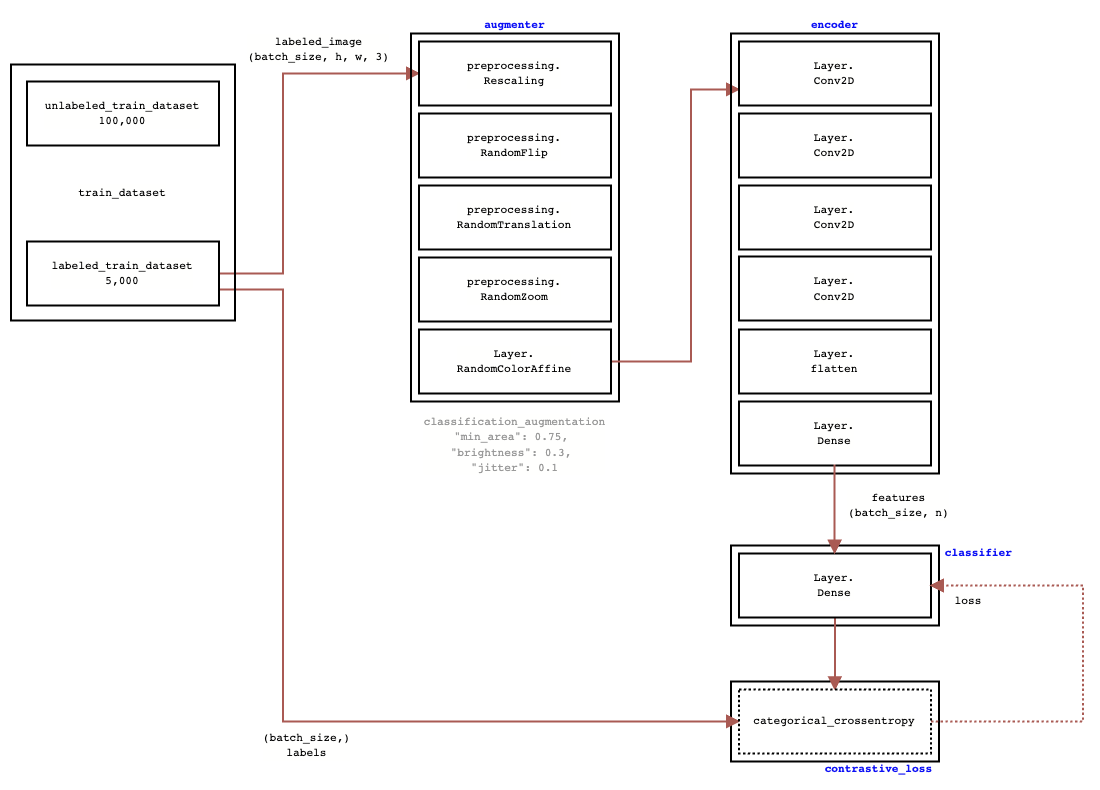

In [ ]:
# 지도학습을 통한 인코더의 파인튜닝
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 [==============================] - 7s 29ms/step - loss: 1.8209 - acc: 0.3012 - val_loss: 1.5810 - val_acc: 0.4024
Epoch 2/20
200/200 [==============================] - 6s 28ms/step - loss: 1.5248 - acc: 0.4264 - val_loss: 1.4447 - val_acc: 0.4686
Epoch 3/20
200/200 [==============================] - 6s 28ms/step - loss: 1.3937 - acc: 0.4696 - val_loss: 1.3358 - val_acc: 0.5081
Epoch 4/20
200/200 [==============================] - 6s 29ms/step - loss: 1.3062 - acc: 0.5244 - val_loss: 1.4303 - val_acc: 0.4861
Epoch 5/20
200/200 [==============================] - 6s 29ms/step - loss: 1.2075 - acc: 0.5664 - val_loss: 1.1784 - val_acc: 0.5725
Epoch 6/20
200/200 [==============================] - 6s 28ms/step - loss: 1.1286 - acc: 0.5838 - val_loss: 1.0852 - val_acc: 0.6109
Epoch 7/20
200/200 [==============================] - 6s 28ms/step - loss: 1.0506 - acc: 0.6230 - val_loss: 1.1801 - val_acc: 0.5774
Epoch 8/20
200/200 [==============================] - 6s 28ms/step - 

## 베이스라인과 비교

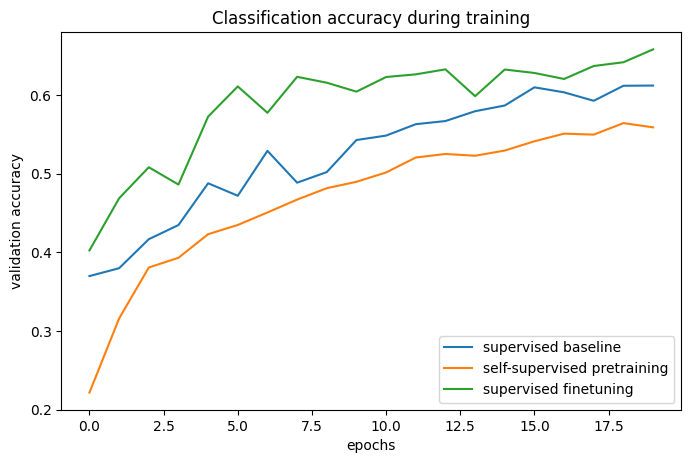

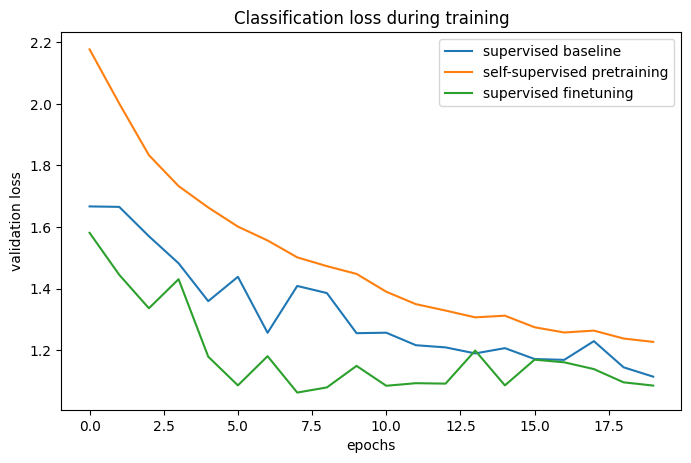

In [ ]:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

두 학습 곡선을 비교해 보면, 대조학습 기반의 사전학습을 사용할 때 더 높은 정확도, 더 낮은 검증 손실을 가진다는 것을 볼 수 있었습니다. 즉, 대조학습 네트워크는 적은 양의 레이블링된 데이터셋만 가지고서도 충분히 더 잘 일반화되는 것이 가능합니다.

## 더 좋게 만들기

### 아키텍처

이 노트북 아이디어의 주인공 SimCLR 에서는 모델의 너비와 깊이를 깊이해가며, 이 성능이 지도학습에 뒤지지 않는다는 사실을 밝혀냈습니다. 이 분야에서는 이 노트북에서 사용된 인코더보다 더 깊고 복잡한 ResNet-50 기반의 인코더가 관용적으로 사용됩니다. 하지만 더 강력하고 깊고 넓은 모델에서는 훈련 시간이 더 느려질 뿐 아니라, 더 많은 메모리가 요구되기 때문에 배치사이즈가 줄어들 수 있다는 사실을 유의해야  합니다.

대조학습 특성상, 배치 차원의 요소들은 모두 다른 이미지입니다. 당연히 이들 사이에는 정보가 최대한 섞이지 않은 채로 유지해야 합니다. 배치정규화 층이 때때로 성능을 더 나쁘게 만들기도 한다는 사실이 알려져 있습니다. 배치 정규화 층에서는 배치 차원에서의 의존성을<sub>intra-batch dependency</sub> 만들어 버리기 때문입니다. 하지만 몇몇 구현의 결과물에서는, 마지막에 추가한 완전연결층에서 배치정규화를 사용하면 성능을 향상시키기도 합니다.

### 초매개변수

이 예제에서 사용하는 초매개변수는 이미 충분히 잘 조작해 두었습니다. 따라서 이 예제에서 이런 매개변수 조절을 하더라도 큰 성능 향상을 얻을 수는 없을거라고 생각합니다. 하지만 만약 완전히 다른 아키텍쳐 (예를 들어 이 노트북에서 사용한 중추 신경망보다 훨씬 더 무겁고 복잡한 신경망을 사용하는 등) 를 사용한다면, 아래 초매개변수와 관련된 내용들을 잘 알아두는 것이 굉장히 유용할 것입니다.

- **배치 사이즈**: 모델의 목적<sub>objective</sub>이 배치 차원의 이미지들 사이에서 구분하는 일을 수행하는 것인만큼, 배치 사이즈는 다른 초매개변수들보다 훨씬 더 중요해집니다. 더 높은 배치 사이즈가, 더 높은 성능을 보입니다. 실제로 논문에서도 이를 보였습니다. 이것을 "충분히 많은 대조적 차이 샘플<sub>negative</sub>" 을 확보해야 하는 문제라고 합니다. 많은 연구에서 이 문제를 해결하기 위해 다양한 시도들을 하게 됩니다. 여러분들도 알다시피 너무 큰 배치 크기는 학습에 부담이 되기 때문입니다.
- **온도**<sub>Temperature</sub>: 위에서 온도변수로 스케일링한다는 내용이 짧게 언급되었습니다. 온도는 크로스-엔트로피 손실의 softmax 분포의 부드러움을 정의하는 중요한 초매개변수입니다. 더 낮은 값은 일반적으로 더 높은 contrastive 정확도를 만들어줍니다. 최근 [ALIGN](https://arxiv.org/pdf/2102.05918.pdf) 에서 보여준 기교는, 이 온도 초매개변수가 그래디언트를 통해 스스로 학습되도록 만들기도 했습니다.
- **이미지 변형의 강도**: 더 강력한 이미지 변형을 통한 사전학습은 모델이 더 어려운 문제를 풀도록 몰아넣습니다. 그만큼 과적합<sub>overfitting</sub> 의 가능성을 줄여 주지만, 너무 높은 강도의 이미지 변형은 이미지의 고유한 정보를 너무 많이 훼손시키고 오히려 성능을 떨어지는 원인이 되기도 합니다. 이러한 데이터 변형 파이프라인 전체 과정은 알고리즘의 중요한 초매개변수를 만들 수 있게 만들어 줍니다. 이미지 변형을 위한 커스텀 파이프라인을 케라스를를 통해 설계하는 방법은 [여기](https://github.com/beresandras/contrastive-classification-keras)에서 더 알아볼 수 있습니다.
- **학습율**<sub>learning rate</sub> 스케줄링: 이 노트북에서는 학습 파이프라인 내내 동일한 학습률을 유지했습니다. 하지만 실제로는 조금씩 학습률이 낮아지도록 스케줄링하는 것이 일반적입니다. [코사인-decay](https://www.tensorflow.org/api_docs/python/tf/keras/experimental/CosineDecay) 스케줄링을 통해 이렇게 학습률 스케줄링 방식을 개선함으로써 성능을 더 높일 수 있습니다.
- **옵티마이저**<sub>optimizer</sub>: 여기서는 기본적인 옵션으로도 충분한 성능을 내는 아담 옵티마이저가 사용되었지만, 모멘텀이 적용된 SGD 를 사용하면 학습시간이 오래 걸리지만 더 좋은 성능을 만들어낼 수 있습니다.

## 관련 연구들

이외에도 인스턴스 레벨 (또는 이미지 레벨) 의 대조학습 방법들이 있습니다.

- [MoCo](https://arxiv.org/abs/1911.05722)
([v2](https://arxiv.org/abs/2003.04297),
[v3](https://arxiv.org/abs/2104.02057)): 이 연구에서는 모멘텀-인코더를 사용해서, 가중치가 타깃 인코더의 지수이동평균<sub>exponential moving average</sub> 을 따라가도록 만들었습니다.
- [SwAV](https://arxiv.org/abs/2006.09882) : 이 연구에서는 이 노트북에서 나타났던 이미지 페어 비교가 아닌 클러스터링을 사용합니다.
- [BarlowTwins](https://arxiv.org/abs/2103.03230) : 이 연구에서는 이미지 페어 비교가 아닌 상관관계 기반의<sub>correlation-based</sub> 목적함수를 사용합니다.

이 노트북과 같이 Colab 노트북 구현을 포함한 MoCo 와 BarlowTwins 의 케라스 구현은 [원저자의 github](https://github.com/beresandras/contrastive-classification-keras) 에서 찾을 수 있습니다.

비슷한 목적함수를 두었지만 노트북의 초반에 소개했던 negative 를 사용하지 않는, 새로운 갈래의 연구 또한 존재합니다.
- [BYOL](https://arxiv.org/abs/2006.07733) : 이 연구에서는 모멘텀-인코더를 사용하고, negative 를 사용하지 않습니다.
- [SimSiam](https://arxiv.org/abs/2011.10566) : 이 연구에서는 모멘텀 인코더도, negative 도 사용하지 않습니다.

제 경험상, 이러한 방법들은 SimCLR 과 달리 밀어내기 유도를 사용하지 않기 때문에, 앞서 말했던 "trivial degenerate solution" 또는 "collapsing" 에 빠지기 쉽습니다. 즉, 학습시키기도 더 까다롭습니다. 비록 이것들이 일반적으로 더 모델의 아키텍처에 의존적이라고 할지라도, SimCLR 과 같이 커다란 배치를 요구하는 모델과 달리 이러한 연구들은 배치 사이즈가 작을 때 성능을 올려 줄 수 있습니다.